# Pipeline для распознавания попугаев: этап детекции и обрезки

Этапы:
1. Загрузка и предобработка изображения
2. Детекция попугая с помощью модели (YOLO или DETR)
3. Обрезка изображения по bounding box'у

In [6]:
!pip install -r requirements.txt

In [7]:
!pip uninstall ultralytics -y
!pip install ultralytics==8.0.124 --force-reinstall

Found existing installation: ultralytics 8.0.124
Uninstalling ultralytics-8.0.124:
  Successfully uninstalled ultralytics-8.0.124
^C


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
import requests
from io import BytesIO

## Вспомогательные функции для визуализации

In [3]:
def plot_image(img, title="Image"):
    """Отображение изображения"""
    if isinstance(img, torch.Tensor):
        img = img.numpy().transpose((1, 2, 0))
    elif isinstance(img, np.ndarray):
        if img.shape[0] == 3:  # CHW -> HWC
            img = img.transpose((1, 2, 0))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

def load_image_from_url(url):
    """Загрузка изображения по URL"""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img


## 1. Загрузка изображения

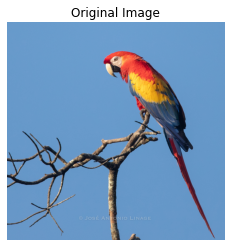

In [4]:
# Пример изображения с попугаем (можно заменить на любое другое)
image_path = "test.jpg"

try:
    image = Image.open(image_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Файл {image_path} не найден. Убедитесь, что он находится в рабочей директории.")

# Преобразование в тензор и отображение
transform = transforms.ToTensor()
img_tensor = transform(image)
plot_image(img_tensor, "Original Image")

## 2. Детекция попугая с помощью YOLO

In [5]:
# Загрузка YOLOv5 (можно заменить на YOLOv8 или другую версию)
model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\user/.cache\torch\hub\ultralytics_yolov5_master


ModuleNotFoundError: No module named 'ultralytics.utils'

C:\Users\user/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 1024x1024 1 bird
Speed: 98.1ms pre-process, 542.4ms inference, 14.1ms NMS per image at shape (1, 3, 640, 640)


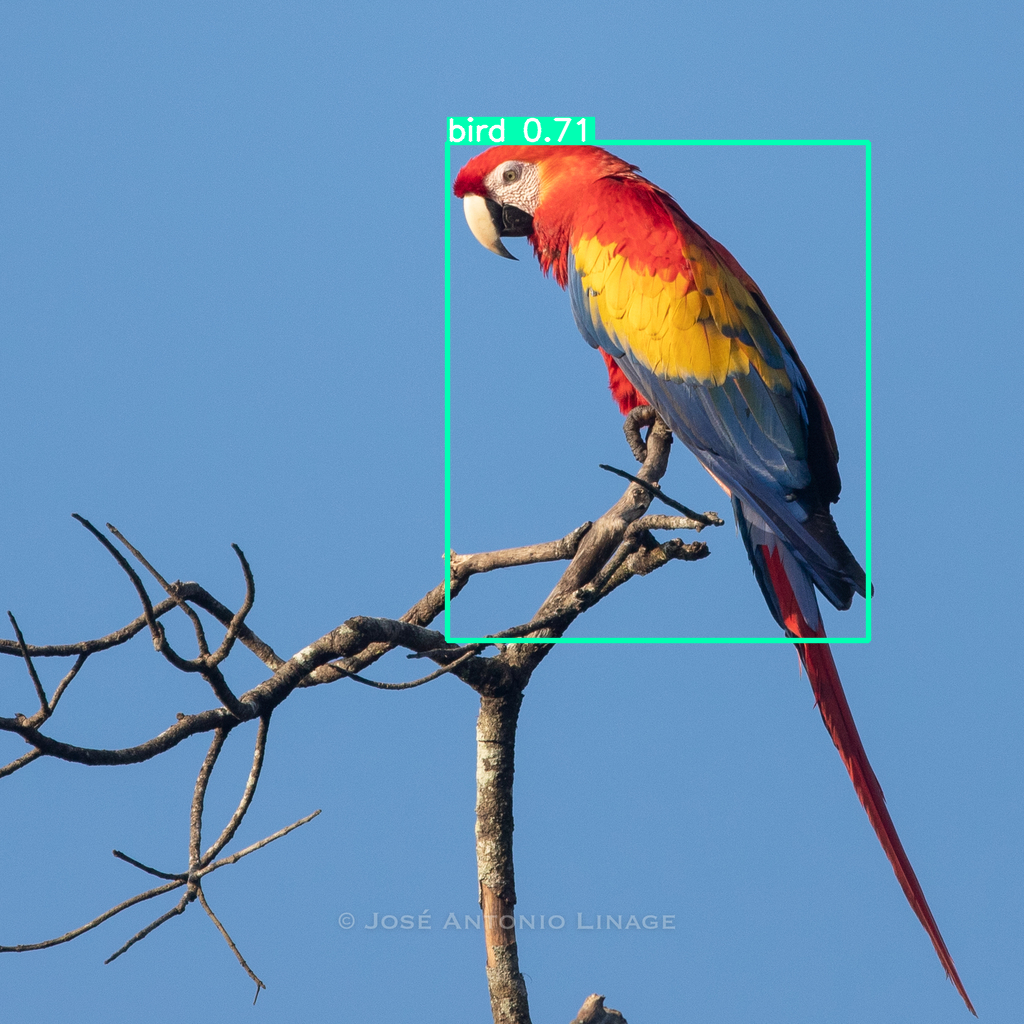

In [ ]:
# Детекция объектов
results = model_yolo([image])

# Отображение результатов детекции
results.print()
results.show()

In [ ]:
# Получение bounding box'а для попугая (класс 'bird')
detections = results.pandas().xyxy[0]
parrot_boxes = detections[detections['name'] == 'bird']

if len(parrot_boxes) == 0:
    raise ValueError("На изображении не обнаружено попугаев")

# Берем первый обнаруженный bounding box (можно добавить логику для выбора нужного)
bbox = parrot_boxes.iloc[0][['xmin', 'ymin', 'xmax', 'ymax']].values.astype(int)
print(f"Bounding box попугая: {bbox}")

Bounding box попугая: [447 142 868 640]


## Альтернатива: Детекция с помощью DETR

In [ ]:
!pip install timm

In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection

In [ ]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model_detr = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

ImportError: 
DetrConvEncoder requires the timm library but it was not found in your environment. You can install it with pip:
`pip install timm`. Please note that you may need to restart your runtime after installation.


In [ ]:
inputs = processor(images=image, return_tensors="pt")
outputs = model_detr(**inputs)

# Конвертируем outputs в bounding boxes
target_sizes = torch.tensor([image.size[::-1]])
results_detr = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.9
)[0]

In [ ]:
# Ищем птиц (класс 16 в COCO)
bird_indices = [i for i, label in enumerate(results_detr["labels"]) if label == 16]

if not bird_indices:
    raise ValueError("DETR не обнаружил птиц на изображении")

# Берем первый обнаруженный bounding box
bbox_detr = results_detr["boxes"][bird_indices[0]].int().tolist()
print(f"DETR Bounding box попугая: {bbox_detr}")

# Визуализация
img_with_boxes = np.array(image.copy())
cv2.rectangle(
    img_with_boxes,
    (bbox_detr[0], bbox_detr[1]),
    (bbox_detr[2], bbox_detr[3]),
    (255, 0, 0),
    2
)
plt.imshow(img_with_boxes)
plt.title("DETR Detection")
plt.axis('off')
plt.show()

## 3. Обрезка изображения по bounding box'у

In [ ]:
def crop_image(img, bbox):
    """Обрезка изображения по bounding box'у"""
    if isinstance(img, torch.Tensor):
        img = img.numpy().transpose((1, 2, 0))
    
    xmin, ymin, xmax, ymax = bbox
    cropped = img[ymin:ymax, xmin:xmax]
    return cropped

In [ ]:
# Обрезка с использованием YOLO bbox
cropped_img = crop_image(img_tensor, bbox)
plot_image(cropped_img, "Cropped Image (YOLO)")

In [ ]:
# Обрезка с использованием DETR bbox
cropped_img_detr = crop_image(img_tensor, bbox_detr)
plot_image(cropped_img_detr, "Cropped Image (DETR)")

## Сохранение обрезанного изображения для следующего этапа

In [ ]:
from torchvision.utils import save_image

# Сохраняем обрезанное изображение
cropped_tensor = transforms.ToTensor()(Image.fromarray((cropped_img * 255).astype(np.uint8)))
save_image(cropped_tensor, "cropped_parrot.jpg")

print("Изображение успешно обрезано и сохранено как 'cropped_parrot.jpg'")